# Imports and libraries

In [1]:
import os

import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

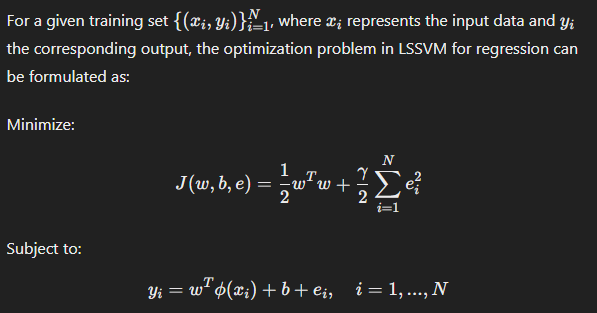

In [2]:
def getProjectRoot():
    REPO_NAME = "Group10_project"
    currentPath = os.getcwd()
    projectRoot = currentPath.split(REPO_NAME)[0] + REPO_NAME +"\\"

    return projectRoot

def getDataPaths(dataPath):
    for root, dirs, files in os.walk(dataPath):
        for file in files:
            # Get the full path to the file
            file_path = os.path.join(root, file)
            print(file_path)


## data processing helpers


In [3]:
def get_date_range_split(df, start_date, end_date, target_column, date_column = "DATETIME"):
    if date_column:
        df[date_column] = pd.to_datetime(df[date_column])
        df_filtered = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
    else:
        df.index = pd.to_datetime(df.index)
        df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]

    # Split into X_test and y_test
    X_test = df_filtered.drop(columns=[target_column, date_column])
    y_test = df_filtered[target_column]
    
    X_test = X_test.to_numpy()
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    return X_test, y_test

## post-prediction helpers

In [4]:

def getEvaluationMetrics(y_test, y_pred, target):
    total_demand_mean = target.mean()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / total_demand_mean
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Calculate Willmott's Index of Agreement (WI)
    def willmott_index(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((np.abs(y_pred - mean_observed) + np.abs(y_true - mean_observed)) ** 2)
        return 1 - (numerator / denominator)

    wi = willmott_index(y_test, y_pred)

    # Calculate Nash–Sutcliffe Efficiency (NSE) coefficient
    def nash_sutcliffe_efficiency(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((y_true - mean_observed) ** 2)
        return 1 - (numerator / denominator)

    nse = nash_sutcliffe_efficiency(y_test, y_pred)

    print(f'MAE: {mae:.2f}')
    print(f'Mean Squared Error (Regression): {mse:.2f}')
    print(f'R^2 Score (Regression): {r2:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'RRMSE: {rrmse:.2f}')
    print(f'Nash–Sutcliffe efficiency coefficient: {nse:.2f}')
    print(f'Willmott index: {wi:.2f}')
    print(f'MAPE is: {mape:.2f}')

def getPlots(y_test, y_pred, residuals = False):
    # plots
    # pred vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual', color='b')
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted', color='r')
    plt.xlabel('Time')
    plt.ylabel('Total Demand')
    plt.title('LSSVM Time Series Forecasting - Actual vs Predicted')
    plt.legend()
    plt.show()

    if(residuals):
        # residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(residuals)), residuals, label='Residuals', color='g')
        plt.axhline(0, color='k', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.title('Residuals of LSSVM Time Series Forecasting')
        plt.show()

## LSSVM Classes

In [5]:
class LSSVMRegressor:
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma

    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _rbf_kernel(self, X1, X2):
        sq_dists = np.sum(X1**2, axis=1).reshape(-1,1) + \
                   np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-sq_dists / (2 * self.sigma**2))

    def fit(self, X, y):
        n_samples = X.shape[0]
        y = y.reshape(-1, 1)
        if self.kernel == 'linear':
            K = self._linear_kernel(X, X)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, X)

        Omega = K + np.eye(n_samples) / self.gamma

        # Construct matrices for the linear system
        ones = np.ones((n_samples, 1))
        A = np.block([[0, ones.T],
                      [ones, Omega]])
        B = np.vstack([0, y])

        # Solve the linear system
        solution = np.linalg.solve(A, B)
        self.b = solution[0]
        self.alpha = solution[1:].flatten()
        self.X_train = X

    def predict(self, X):
        if self.kernel == 'linear':
            K = self._linear_kernel(X, self.X_train)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, self.X_train)
        predictions = np.dot(K, self.alpha) + self.b
        return predictions.flatten()

# Wrapper for GridSearchCV
class LSSVMRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma
        self.model = LSSVMRegressor(gamma=self.gamma, kernel=self.kernel, sigma=self.sigma)

    def fit(self, X, y):
        self.model.gamma = self.gamma
        self.model.kernel = self.kernel
        self.model.sigma = self.sigma
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Data assets

In [6]:
projRoot = getProjectRoot()
print(getDataPaths(projRoot + "\\data\\"))
print(getDataPaths(projRoot + "\\extracted_data\\"))

f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\a.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\b.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\c.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\d.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partaa
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partab
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\temperature_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\totaldemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\SILO\40842 BRISBANE.csv
f:\UNSW Master of Data Science\ZZSC9020

# Data loading

In [10]:
rollingWindowNSW = pd.read_csv(projRoot + "data\\SILO\\NSW_Rolling_Data.csv")
rollingWindowNSW

,DATETIME,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,bushfire,flood,temp_change,high_temp_change,humid_change,high_humid_change,rain_change,high_rain_change,high_humid_past_week,high_rain_past_week,high_temp_past_week
0,2010-01-01,7801.35,25.09,0.2,5.2,14.6,23.1,76.35,0.0,0.0,0.07,0,6.60,0,0.2,0,0,0,0
1,2010-01-02,8017.46,24.77,0.0,5.9,18.4,22.0,67.80,0.0,0.0,-0.32,0,-8.55,0,-0.2,0,0,0,0
2,2010-01-03,7399.90,19.43,15.2,1.9,7.3,19.1,83.25,0.0,0.0,-5.34,1,15.45,1,15.2,1,0,0,0
3,2010-01-04,8241.72,20.63,0.2,3.4,14.4,18.2,75.15,0.0,0.0,1.20,0,-8.10,0,-15.0,1,1,1,1
4,2010-01-05,8827.81,22.66,0.0,6.8,28.1,16.9,65.35,0.0,0.0,2.03,0,-9.80,0,-0.2,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,2021-03-14,7092.58,18.04,15.8,3.7,3.1,19.9,89.45,0.0,0.0,-5.61,1,17.75,1,13.8,1,0,0,0
4091,2021-03-15,6930.62,17.12,9.4,3.7,19.2,11.6,61.25,0.0,0.0,-0.92,0,-28.20,1,-6.4,0,1,1,1
4092,2021-03-16,7330.38,18.26,0.0,2.3,9.1,14.3,73.75,0.0,1.0,1.14,0,12.50,1,-9.4,1,1,1,1
4093,2021-03-17,7428.19,19.41,7.0,4.1,11.3,17.3,76.60,0.0,1.0,1.15,0,2.85,0,7.0,0,1,1,1


In [ ]:

rollingWindowQLD = pd.read_csv(projRoot + "data\SILO\QLD_Rolling_Data.csv")
rollingWindowQLD = rollingWindowQLD.drop(["high_temp_change", "high_rain_change"])
rollingWindowQLD

In [20]:
dailyMergedNSW = pd.read_csv(projRoot + "data\\SILO\\daily_merged_nsw.csv")
dailyMergedNSW = dailyMergedNSW.dropna()
data = dailyMergedNSW
data.columns

Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH'],
      dtype='object')

# Exploratory data analysis 

## Data summary

In [21]:
summary_stats = data.describe()
summary_stats

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH
count,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000
mean,8112.775748,17.412537,2.317009,4.186730,16.000562,14.172507,68.077994
std,798.863209,4.692215,8.280795,2.310721,7.423272,4.793369,10.604804
min,6043.800000,4.940000,0.000000,0.300000,1.000000,4.000000,19.700000
25%,7557.305000,13.470000,0.000000,2.400000,10.500000,10.100000,63.100000
50%,8062.475000,17.580000,0.000000,3.700000,14.700000,13.800000,69.400000
75%,8649.080000,21.150000,0.400000,5.700000,21.400000,18.000000,74.600000
max,11539.820000,33.310000,159.600000,16.000000,34.400000,27.900000,96.250000


## Time series plot

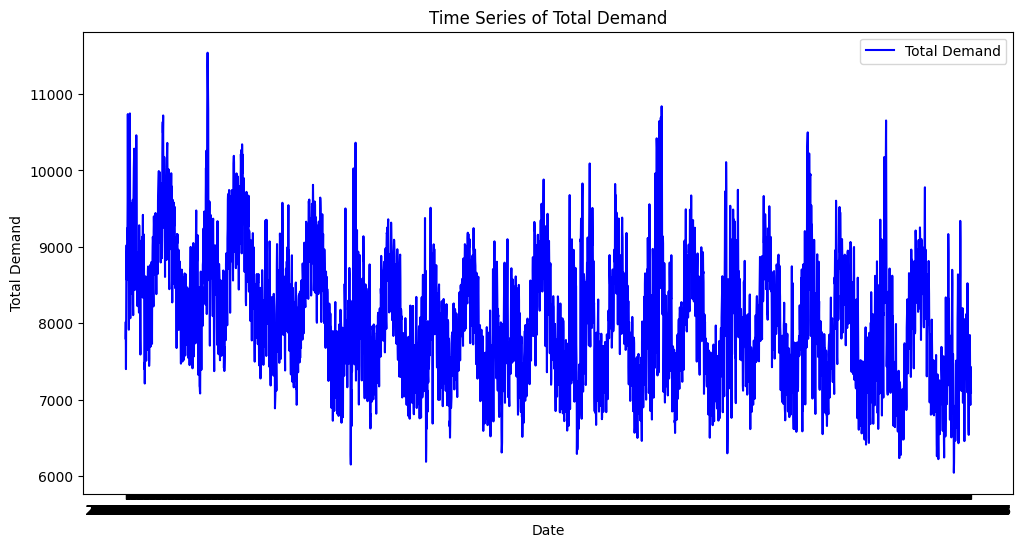

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(data['DATETIME'], data['TOTALDEMAND'], label='Total Demand', color='b')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.title('Time Series of Total Demand')
plt.legend()
plt.show()


## Correlation map

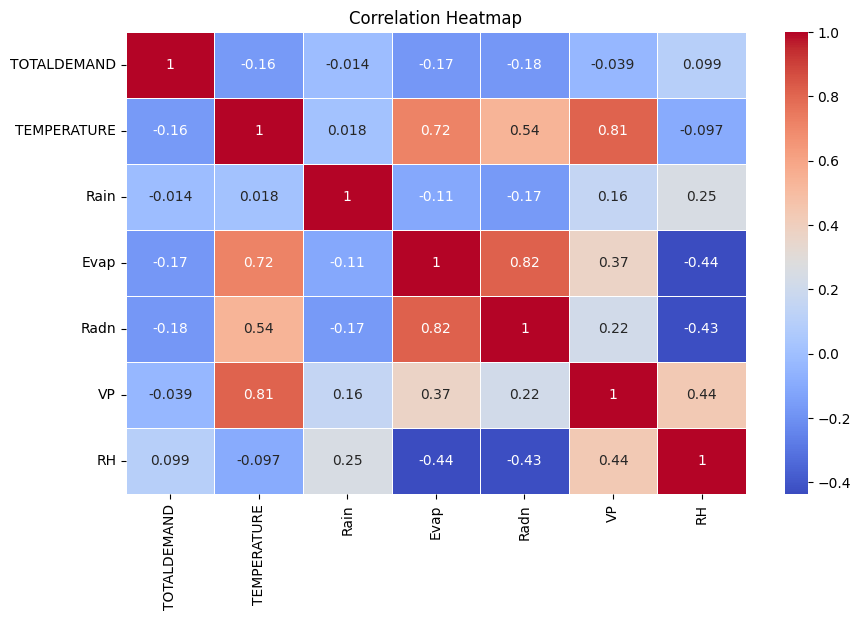

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Autocorrelation and partial autocorrelation for TOTALDEMAND

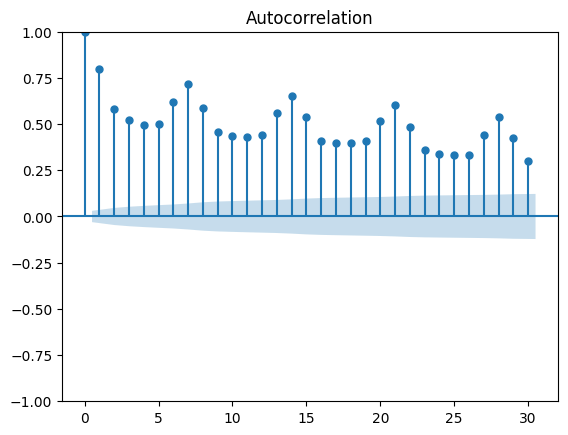

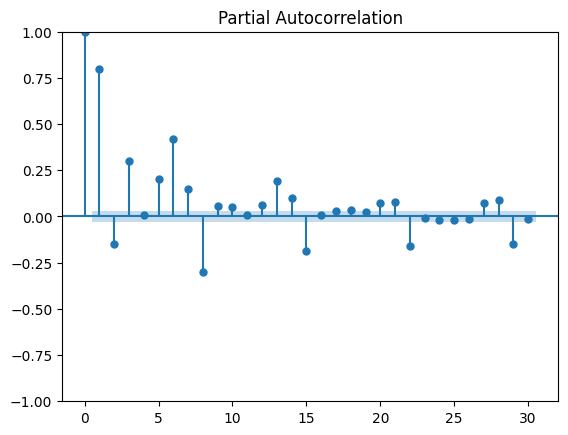

In [24]:
plot_acf(data['TOTALDEMAND'], lags=30)
plot_pacf(data['TOTALDEMAND'], lags=30)
plt.show()

## Correlation of different lags with target variable

In [25]:
data.columns
# TODO: np.sqrt(temp)

Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH'],
      dtype='object')

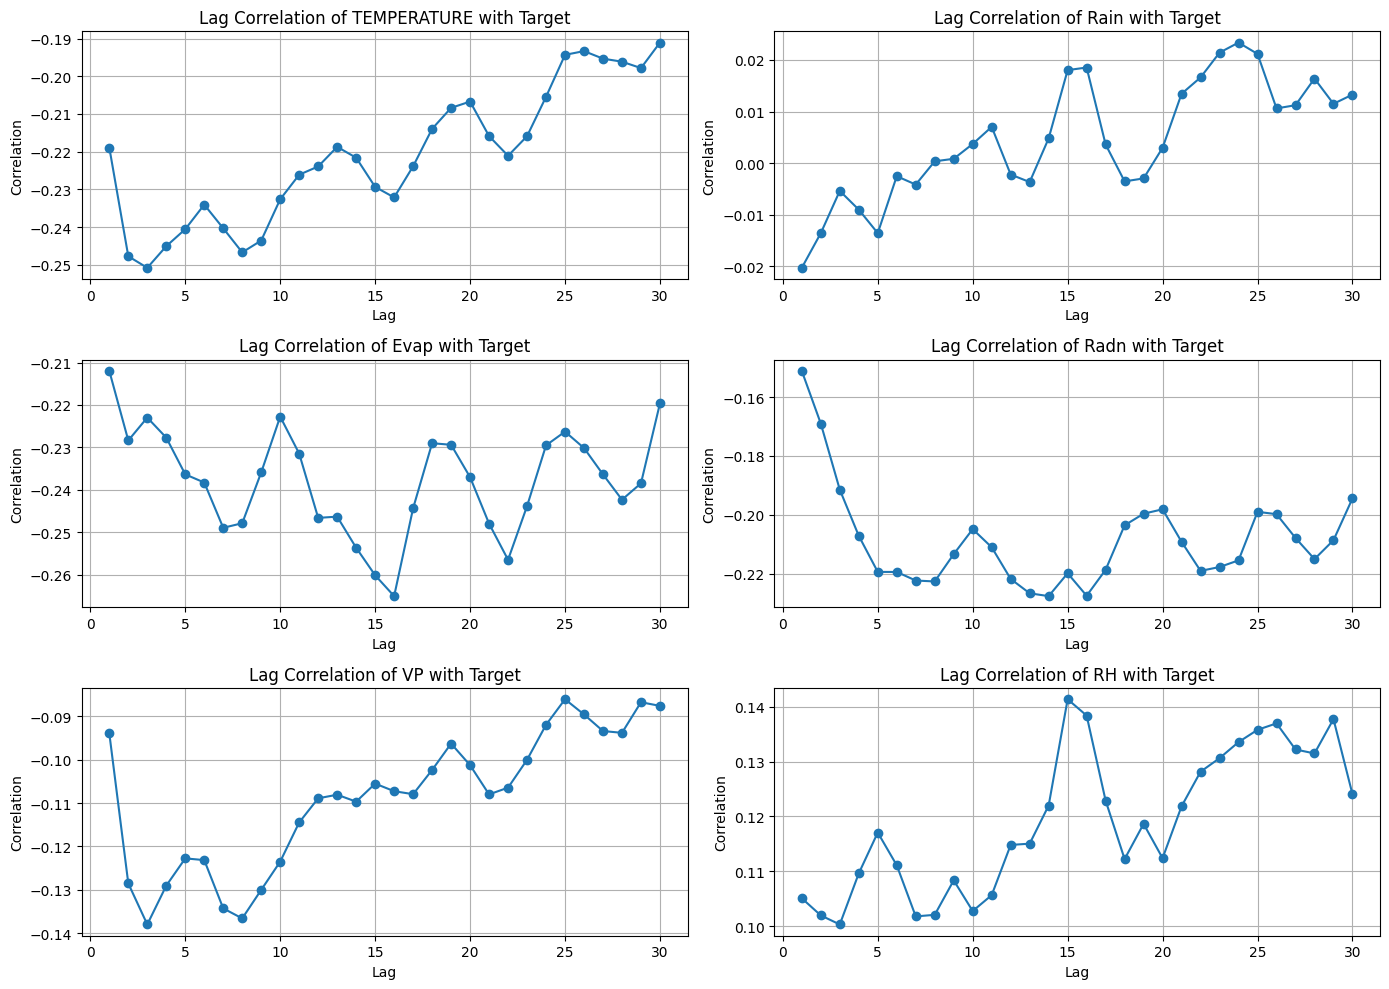

In [31]:
# Number of lags to compute
def getLagCorrelationMatrix(df):
    lagged_data = {}
    num_lags = 30
    targetvar = 'TOTALDEMAND'
    # Create lagged features for each feature and store in a dictionary
    features = ['TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP', 'RH']
    for feature in features:
        for lag in range(1, num_lags + 1):
            lagged_data[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

    # Concatenate all lagged features into a new DataFrame
    lagged_df = pd.concat(lagged_data, axis=1)

    # Drop NaN values caused by lagging
    lagged_df.dropna(inplace=True)
    df = df.loc[lagged_df.index]

    # Initialize a figure with 2x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    # Loop through each feature and plot lagged correlations
    for i, feature in enumerate(features):
        # Calculate correlations for the current feature
        lagged_correlations = []
        for lag in range(1, num_lags + 1):
            correlation = lagged_df[f'{feature}_lag_{lag}'].corr(df[targetvar])
            lagged_correlations.append(correlation)
        
        # Get subplot axes
        ax = axes[i // 2, i % 2]
        # Plot the correlations
        ax.plot(range(1, num_lags + 1), lagged_correlations, marker='o')
        ax.set_title(f'Lag Correlation of {feature} with Target')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Correlation')
        ax.grid(True)

getLagCorrelationMatrix(data)
plt.tight_layout()
plt.show()

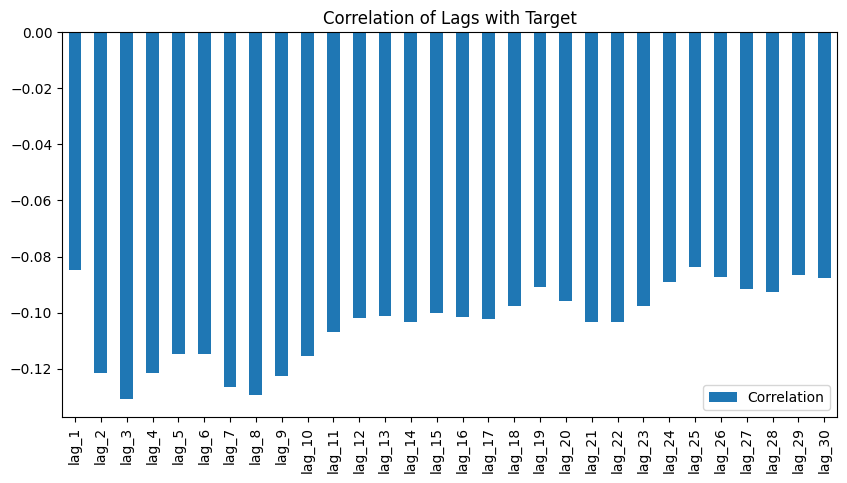

In [32]:
# Calculate correlation for different lags
max_lag = 30
correlations = {}
for lag in range(1, max_lag + 1):
    correlations[f'lag_{lag}'] = data['VP'].shift(lag).corr(data['TOTALDEMAND'])

# Convert to a DataFrame and visualize
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
corr_df.plot(kind='bar', figsize=(10, 5))
plt.title('Correlation of Lags with Target')
plt.show()

## Feature engineering

### Add lag variables

In [111]:
# TODO: generate lag features using autocorrelation plots and correlation analysis
lag_steps = [1, 7, 14]

for lag in lag_steps:
    data[f'TOTALDEMAND_lag_1'] = data['TOTALDEMAND'].shift(1)
    # data[f'TEMPERATURE_lag_{lag}'] = data['TEMPERATURE'].shift(lag)


### Add date time variables

# Model Training

## Data summary before training

In [119]:
data.shape
data.dropna(inplace=True)
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

features = data.drop(columns=['DATETIME', 'TOTALDEMAND'])
target = data['TOTALDEMAND']

features_numpy = features.to_numpy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_numpy)

print('\n'.join(features.columns))

TEMPERATURE
Rain
Evap
Radn
VP
RH
TOTALDEMAND_lag_1
TEMPERATURE_lag_7
TEMPERATURE_lag_14
TEMPERATURE_lag_30


## Data splits

In [121]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle=False)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

## LSSVM Regression model training

In [155]:
# fit and predict
lssvm_model = LSSVMRegressor(gamma=1, kernel='rbf', sigma=7)
lssvm_model.fit(X_train, y_train)

## Test set

MAE: 321.99
Mean Squared Error (Regression): 169918.31
R^2 Score (Regression): 0.73
RMSE: 412.21
RRMSE: 0.05
Nash–Sutcliffe efficiency coefficient: -1368.71
Willmott index: 0.39
MAPE is: 10.67


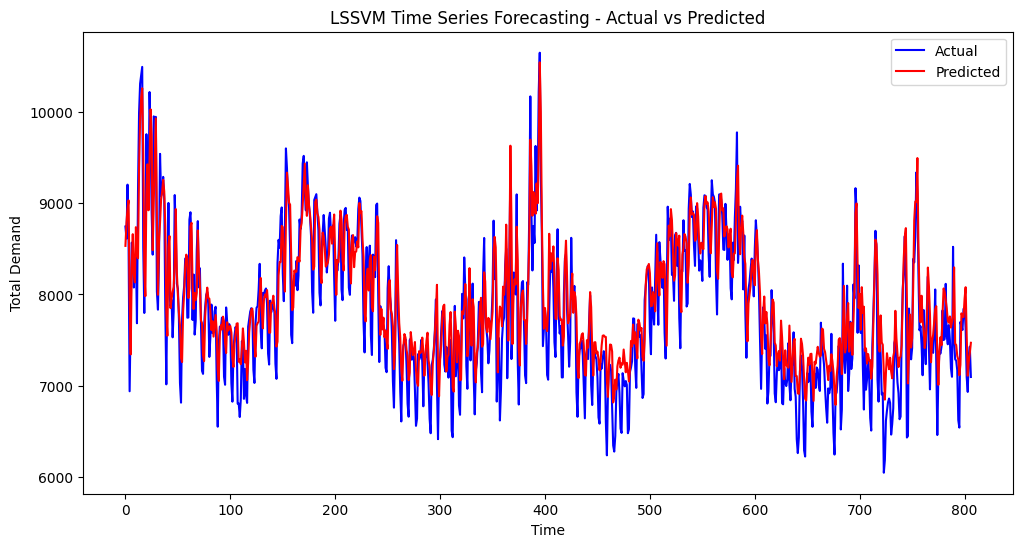

In [156]:
y_pred = lssvm_model.predict(X_test)
getEvaluationMetrics(y_test, y_pred, target)
getPlots(y_test, y_pred, residuals = False)

## Validation set

MAE: 657.78
Mean Squared Error (Regression): 618215.91
R^2 Score (Regression): -0.65
RMSE: 786.27
RRMSE: 0.10
Nash–Sutcliffe efficiency coefficient: -0.65
Willmott index: 0.70
MAPE is: 9.05


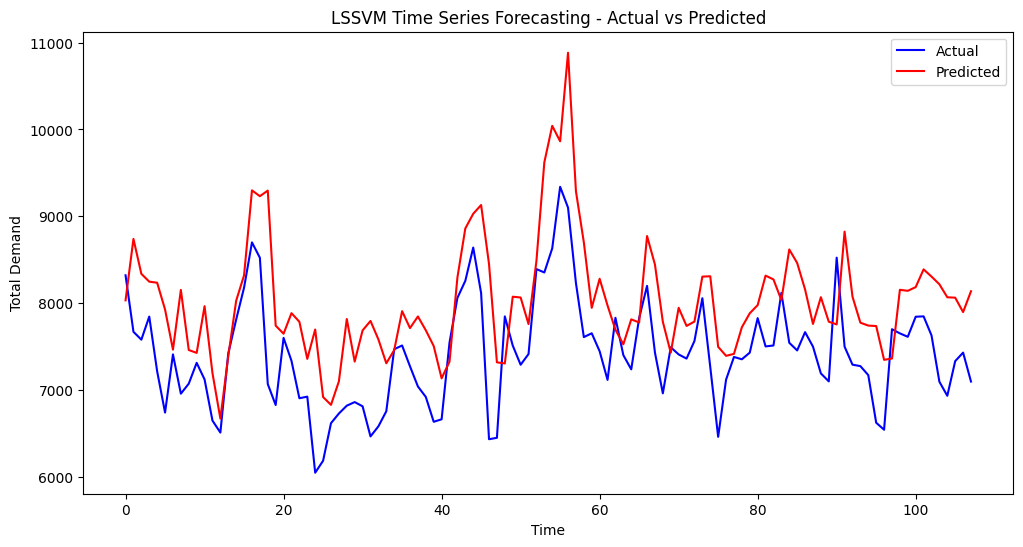

In [127]:
# "2020-12-01", "2021-03-18"

X_test_custom, y_test_custom = get_date_range_split(
    data, "2020-12-01", "2021-03-18", "TOTALDEMAND"
)

y_pred_custom = lssvm_model.predict(X_test_custom)
getEvaluationMetrics(y_test_custom, y_pred_custom, target)
getPlots(y_test_custom, y_pred_custom)

## Hyperparameter tuning with gridsearch

Best Parameters (Regression): {'gamma': 100, 'sigma': 10}
MAE: 306.80
Mean Squared Error (Regression): 153575.06
R^2 Score (Regression): 0.76
RMSE: 391.89
RRMSE: 0.05
Nash–Sutcliffe efficiency coefficient: -1393.25
Willmott index: 0.39
MAPE is: 10.72


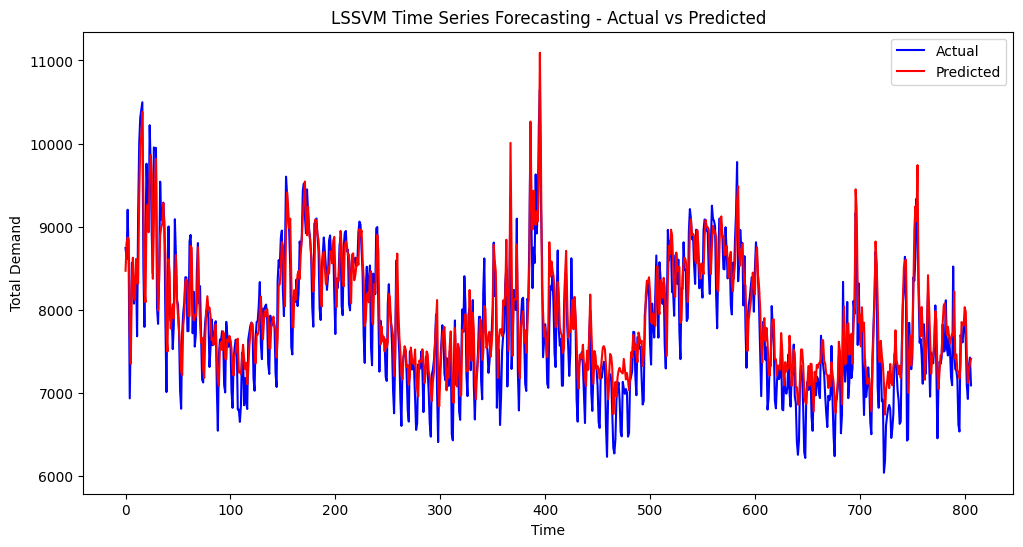

In [129]:
param_grid = {
    'gamma': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100],
    'sigma': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100]
}

grid_search = GridSearchCV(LSSVMRegressorWrapper(kernel='rbf'), param_grid, cv=3, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

print("Best Parameters (Regression):", grid_search.best_params_)

# Evaluate with best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

getEvaluationMetrics(y_test, y_pred_best, target)
getPlots(y_test, y_pred_best, residuals=False)

# Other notes:

In [157]:
    # experiment more with lag features,
    # find more literature with existing lag features
    # provide reasoning
        # other people have done something
            # literature has shown that lag features are used in exisiting models
            # no access and SILO data lagging was not required in exisiting literature
        # experiment and testing
        # time constraints
    # discuss in future section
# Drop rows with NaN values introduced by lagging
